In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import VisionDataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import transforms
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
from torchvision import datasets, models, transforms
import copy
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision.models import AlexNet, AlexNet_Weights
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
lib = '/content/gdrive/MyDrive/Senior Year/Semester 2/ITCS 4152 (Computer Vision)/Group Work/The Best Group /Backup/lib'
!cd '/content/gdrive/MyDrive/Senior Year/Semester 2/ITCS 4152 (Computer Vision)/Group Work/The Best Group /Backup/lib'

/bin/bash: line 0: cd: /content/gdrive/MyDrive/Senior Year/Semester 2/ITCS 4152 (Computer Vision)/Group Work/The Best Group /Backup/lib: No such file or directory


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/lib'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Batch size 16, decrease number of output neurons for the second to last fully connected layer since there are only 71 classes compared to 1,000 with image net and updating all model parameters

In [7]:
model_ft =models.alexnet(weights="IMAGENET1K_V1")


print(model_ft.classifier[6])
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.features[10] = nn.Conv2d(256,256,3)

model_ft.classifier[4] = nn.Linear(4096, 2048)

model_ft.classifier[6] = nn.Linear(2048, 71)
print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 52.8MB/s]


Linear(in_features=4096, out_features=1000, bias=True)
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_feature

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
model_ft_res =models.resnet18(weights="IMAGENET1K_V1")
for param in model_ft_res.parameters():
    param.requires_grad = False

num_ftrs = model_ft_res.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft_res.fc = nn.Linear(num_ftrs, 71)
model_ft_res = model_ft_res.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_res.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]


In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
model_ft_t =models.swin_t(weights="IMAGENET1K_V1")
for param in model_ft_t.parameters():
    param.requires_grad = False
print(model_ft_t.head)


num_ftrs = model_ft_t.head.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft_t.head = nn.Linear(num_ftrs, 71)
print(model_ft_t.head)
model_ft_t = model_ft_t.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_t.head.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Linear(in_features=768, out_features=1000, bias=True)
768
Linear(in_features=768, out_features=71, bias=True)


In [ ]:
model_ft_t = train_model(model_ft_t, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 2.7139 Acc: 0.5938
test Loss: 1.1774 Acc: 0.8957

Epoch 1/9
----------
train Loss: 1.1634 Acc: 0.8134
test Loss: 0.4672 Acc: 0.9286

Epoch 2/9
----------
train Loss: 0.7860 Acc: 0.8401
test Loss: 0.2946 Acc: 0.9429

Epoch 3/9
----------
train Loss: 0.6690 Acc: 0.8454
test Loss: 0.2334 Acc: 0.9543

Epoch 4/9
----------
train Loss: 0.6091 Acc: 0.8497
test Loss: 0.1980 Acc: 0.9643

Epoch 5/9
----------
train Loss: 0.5633 Acc: 0.8555
test Loss: 0.1770 Acc: 0.9600

Epoch 6/9
----------
train Loss: 0.5381 Acc: 0.8561
test Loss: 0.1632 Acc: 0.9600

Epoch 7/9
----------
train Loss: 0.5191 Acc: 0.8635
test Loss: 0.1618 Acc: 0.9614

Epoch 8/9
----------
train Loss: 0.5108 Acc: 0.8631
test Loss: 0.1604 Acc: 0.9614

Epoch 9/9
----------
train Loss: 0.5144 Acc: 0.8622
test Loss: 0.1591 Acc: 0.9614

Training complete in 12m 36s
Best val Acc: 0.964286


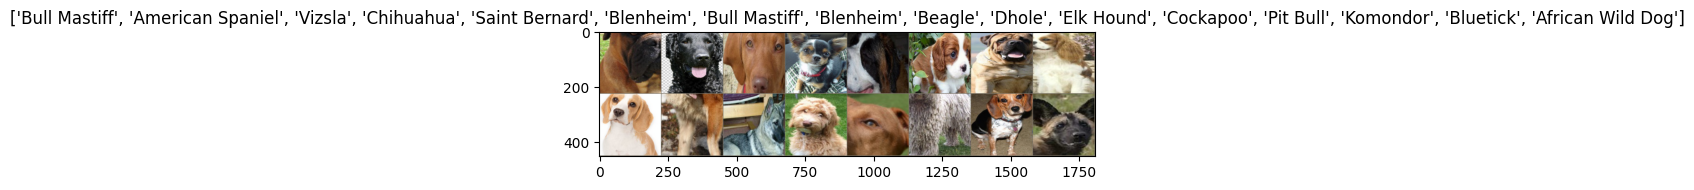

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

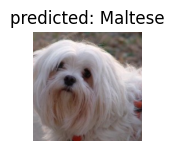

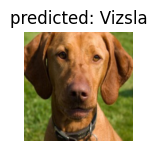

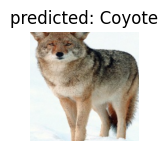

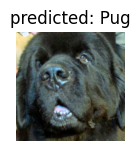

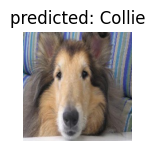

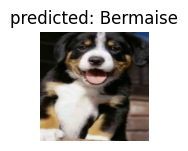

In [ ]:
visualize_model(model_ft)
